<a href="https://colab.research.google.com/github/fabianimarco98/cinema-prediction-ML/blob/main/SC_model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statistics  as stat
import matplotlib.pyplot as plt
from collections import Counter
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from google.colab import drive
import tensorflow as tf
from datetime import datetime
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import itertools
import ast
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csv/df_coded.csv",sep=",")
#print(df.dtypes.value_counts())
prefixes = ['genre_','cast_','ts_','lang_','dir_','prod_','coll_']
for p in prefixes:
    n = sum(1 for c in df.columns if c.startswith(p))
#    print(f"{p:<8} → {n} columns")
#print(f"Total columns: {df.shape[1]}")

In [ ]:
%%capture
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt


# 1) Identify your dummy blocks
cast_cols   = [c for c in df.columns if c.startswith("cast_")]
#kw_cols     = [c for c in df.columns if c.startswith("kw_")]
genre_cols  = [c for c in df.columns if c.startswith("genre_")]
lang_cols=[c for c in df.columns if c.startswith("lang_")]
dir_cols=[c for c in df.columns if c.startswith("dir_")]
prod_cols=[c for c in df.columns if c.startswith("prod_")]
coll_cols=[c for c in df.columns if c.startswith("coll_")]

# 2) Helper to plot cumulative variance
def plot_cumvar(block_cols, title):
    X = df[block_cols]
    svd = TruncatedSVD(n_components=len(block_cols)-1, random_state=42)
    svd.fit(X)
    cumvar = svd.explained_variance_ratio_.cumsum()
    plt.figure()
    plt.plot(range(1, len(cumvar)+1), cumvar)
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.title(title)
    plt.grid(True)
    plt.show()

# 3) Plot for each block
plot_cumvar(cast_cols,  "Cast features")
#plot_cumvar(kw_cols,    "Keyword features")
plot_cumvar(genre_cols, "Genre features")
plot_cumvar(lang_cols, "Language features")
plot_cumvar(dir_cols, "director features")
plot_cumvar(prod_cols, "production features")
plot_cumvar(coll_cols,"collection")

InvalidParameterError: The 'n_components' parameter of TruncatedSVD must be an int in the range [1, inf). Got -1 instead.

| Feature block            | # original cols | \~90% var @     | \~95% var @     | Recommendation |
| ------------------------ | --------------- | --------------- | --------------- | -------------- |
| **Cast** (31 cols)       | 31              | \~15 components | \~22 components | **20**         |
| **Keywords** (41 cols)   | 41              | \~15 components | \~30 components | **25**         |
| **Genres** (11 cols)     | 11              | \~5  components | \~9  components | **6**          |
| **Languages** (11 cols)  | 11              | \~3  components | \~6  components | **4–5**        |
| **Directors** (11 cols)  | 11              | \~4  components | \~10 components | **5**          |
| **Production** (11 cols) | 11              | \~4  components | \~10 components | **5**          |


In [ ]:
df=df.drop(["title","month","id","belongs_to_collection","in_collection","weekday"],axis=1)
print(df.columns.tolist())

['total', 'popularity', 'rating', 'budget', 'keywords', 'collection_name', 'month_sin', 'month_cos', 'wd_sin', 'wd_cos', 'ts_17', 'ts_20', 'lang_ar', 'lang_de', 'lang_dz', 'lang_en', 'lang_es', 'lang_fa', 'lang_fr', 'lang_ga', 'lang_hu', 'lang_it', 'lang_ja', 'lang_ko', 'lang_no', 'lang_pl', 'lang_pt', 'lang_ru', 'lang_so', 'lang_uk', 'lang_zh', 'dir_Aaron Horvath', 'dir_Barry Jenkins', 'dir_Barry Sonnenfeld', 'dir_Checco Zalone', 'dir_Gianluca Leuzzi', 'dir_James Cameron', 'dir_Mike Rossiter', 'dir_Other', 'dir_Paola Cortellesi', 'dir_Roberto Benigni', 'dir_Todd Phillips', 'prod_20th Century Studios', 'prod_DreamWorks Animation', 'prod_Marvel Studios', 'prod_Nova', 'prod_Other', 'prod_Paramount Pictures', 'prod_Taodue Film', 'prod_Universal Pictures', 'prod_Walt Disney Pictures', 'prod_Warner Bros. Pictures', 'prod_Wildside', 'genre_ ', 'genre_,', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_[', 'genre_]', 'cast_ 

In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# 2) Apply TruncatedSVD with the chosen n_components
#which dummy columns to reduce, e.g. cast_cols is a list of all "cast_*" columns and how many SVD components to keep for that block
svd_params = {
    'cast'  : (cast_cols,  30),
    #'kw'    : (kw_cols,    30),
    'genre' : (genre_cols,  10),
    'lang'  : (lang_cols,   6),
    'dir'   : (dir_cols,    10),
    'prod'  : (prod_cols,   8)
    #'coll' :(coll_cols, 3)
}

#Loop over each block

for name, (cols, n_comp) in svd_params.items():
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    mat = svd.fit_transform(df[cols])
    for i in range(n_comp):
        df[f"{name}_svd_{i}"] = mat[:, i]
    # drop the original dummies
    df.drop(columns=cols, inplace=True)

# 3) Ready for modeling
#features: a list of all column names except the identifiers (title, id) and the target (total)
features = [c for c in df.columns if c not in ['title','id','total']]
#X: your final feature matrix, shape (n_samples, n_final_features)
X = df[features].values
#y: the target vector of ticket counts
y = df['total'].values

KeyError: "None of [Index(['cast_ ', 'cast_'', 'cast_,', 'cast_A', 'cast_B', 'cast_C', 'cast_D',\n       'cast_F', 'cast_G', 'cast_H', 'cast_J', 'cast_L', 'cast_M', 'cast_N',\n       'cast_Other', 'cast_P', 'cast_R', 'cast_S', 'cast_T', 'cast_[',\n       'cast_]', 'cast_a', 'cast_b', 'cast_c', 'cast_d', 'cast_e', 'cast_g',\n       'cast_h', 'cast_i', 'cast_k', 'cast_l', 'cast_m', 'cast_n', 'cast_o',\n       'cast_r', 'cast_s', 'cast_t', 'cast_u', 'cast_v', 'cast_w', 'cast_y'],\n      dtype='object')] are in the [columns]"

# Explaination

1. Instantiate a TruncatedSVD with your chosen n_comp.

2. Fit & transform only the sub-matrix df[cols] → mat is now (n_samples × n_comp).

3. Write back each of the n_comp SVD columns into your DataFrame, named "{name}_svd_0", "{name}_svd_1", …

4. Drop the original high-dimensional dummy columns (cols), since their information is now captured by the dense SVD components.

By the end of this loop, you’ve replaced:
*   31 cast dummies ➔ 20 cast_svd_* features
*   41 keyword dummies ➔ 25 kw_svd_* features
*   11 genre dummies ➔ 6 genre_svd_* features
*   …and so on for the other blocks.

Test RMSE: 48.66
Test R²: 0.174

Top 20 features by importance:
prod_svd_6     0.315900
popularity     0.047868
month_cos      0.029826
prod_svd_1     0.028433
wd_sin         0.026387
cast_svd_3     0.022258
cast_svd_1     0.021474
wd_cos         0.021119
month_sin      0.021003
genre_svd_9    0.020906
cast_svd_0     0.020722
cast_svd_15    0.019282
cast_svd_22    0.019154
genre_svd_8    0.018002
cast_svd_7     0.016985
cast_svd_26    0.016134
genre_svd_7    0.013322
genre_svd_1    0.013065
cast_svd_13    0.012495
cast_svd_2     0.012351
dtype: float64


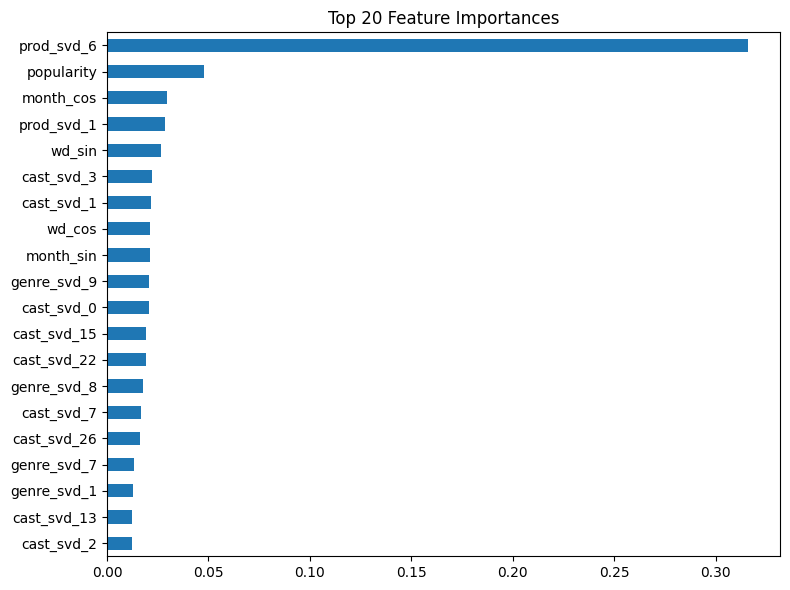

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 0) Ensure 'total' is numeric and drop any rows where it's NaN
df['total'] = pd.to_numeric(df['total'], errors='coerce')
df = df.dropna(subset=['total']).reset_index(drop=True)

# 1) Select only numeric feature columns (auto‐drops any object/dict columns)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('total')  # exclude the target
X = df[numeric_cols].values
y = df['total'].values

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Instantiate & fit Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4) Predict & evaluate
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

# 5) Feature importances
feat_imp = pd.Series(rf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
print("\nTop 20 features by importance:")
print(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()